<a href="https://colab.research.google.com/github/sanskarmalviya7/Tree-Recognisition-and-Count/blob/main/tree_recognisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree Recognisition Using kml

In [ ]:
# @title Install Dependancies
!pip -q install DeepForest
!pip -q install selenium
!pip -q install folium

# KML to PNG Converter

In [2]:
# @title KML To LINK
import os
import folium
import xml.etree.ElementTree as ET

def create_kmlmaps(kml_folder, output_folder):
    latitudes = []
    longitudes = []
    bounds = []

    m = folium.Map(location=[0, 0], zoom_start=10, tiles='http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google Satellite', name='Satellite', max_native_zoom=50, max_zoom=50)

    for filename in os.listdir(kml_folder):
        if filename.endswith('.kml'):
            kml_path = os.path.join(kml_folder, filename)

            tree = ET.parse(kml_path)
            root = tree.getroot()

            features = []
            for placemark in root.findall('.//{http://www.opengis.net/kml/2.2}Placemark'):
                geometry_element = placemark.find('.//{http://www.opengis.net/kml/2.2}Polygon') or placemark.find('.//{http://www.opengis.net/kml/2.2}LineString')
                if geometry_element is not None:
                    coordinates = geometry_element.find('.//{http://www.opengis.net/kml/2.2}coordinates').text.strip()
                    coordinates = [list(map(float, coord.split(','))) for coord in coordinates.split()]

                    description_element = placemark.find('.//{http://www.opengis.net/kml/2.2}description')
                    description_text = description_element.text.strip() if description_element is not None else ''

                    lats = [coord[1] for coord in coordinates]
                    lons = [coord[0] for coord in coordinates]
                    avg_lat = sum(lats) / len(lats)
                    avg_lon = sum(lons) / len(lons)

                    latitudes.append(avg_lat)
                    longitudes.append(avg_lon)

                    bounds.extend(coordinates)

                    feature = {
                        "type": "Feature",
                        "properties": {
                            "description": description_text,
                            "color": "red",
                            "fillColor": "blue"
                        },
                        "geometry": {
                            "type": "Polygon",
                            "coordinates": [coordinates]
                        }
                    }
                    features.append(feature)

            geojson_data = {
                "type": "FeatureCollection",
                "features": features
            }

            folium.GeoJson(
                geojson_data,
                name=filename.split('.')[0],
                style_function=lambda x: {
                    "color": x["properties"]["color"],
                    "fillColor": x["properties"]["fillColor"],
                    "fillOpacity": 0.01
                },
                tooltip=folium.GeoJsonTooltip(fields=['description'], labels=False) if any(feature["properties"].get("description") for feature in features) else None
            ).add_to(m)

    if bounds:
        min_lat, min_lon = min(bounds, key=lambda x: x[1])[1], min(bounds, key=lambda x: x[0])[0]
        max_lat, max_lon = max(bounds, key=lambda x: x[1])[1], max(bounds, key=lambda x: x[0])[0]
        bounds = [[min_lat, min_lon], [max_lat, max_lon]]

        m.fit_bounds(bounds)

    folium.TileLayer(tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', attr='OpenStreetMap', name='OSM', max_native_zoom=20, max_zoom=20).add_to(m)
    folium.TileLayer(tiles='http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google Normal', name='Normal', max_native_zoom=20, max_zoom=20).add_to(m)
    folium.TileLayer(tiles='http://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google Hybrid', name='Hybrid', max_native_zoom=20, max_zoom=20).add_to(m)

    folium.LayerControl().add_to(m)

    map_file = os.path.join(output_folder, "plot_map.html")
    m.save(map_file)

    print(f"Map saved to {map_file}")
    return map_file

output_link = create_kmlmaps('/content/kml', '/content/')
sam = f"file://{output_link}"
print(f"Map link: file://{output_link}")

Map saved to /content/plot_map.html
Map link: file:///content/plot_map.html


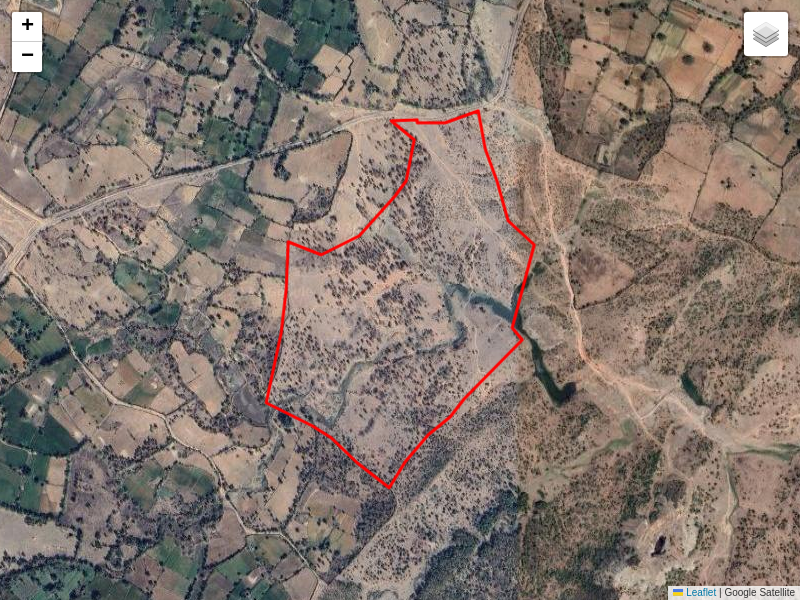

In [3]:
# @title Etract image from link
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from IPython.display import Image
import time

chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_driver_path = '/usr/lib/chromium-browser/chromedriver'

driver = webdriver.Chrome(options=chrome_options)
driver.get(sam)
time.sleep(5)
screenshot_path = '/content/map_screenshot.png'
driver.save_screenshot(screenshot_path)
driver.quit()
Image(screenshot_path)

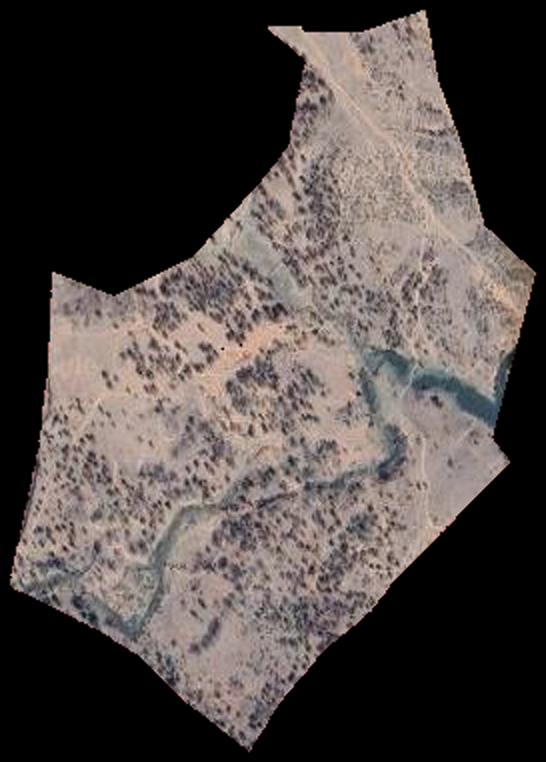

In [4]:
# @title Crop image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_red_polygon(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    lower_red = np.array([160, 100, 100])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red, upper_red)
    mask = cv2.bitwise_or(mask1, mask2)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0 * cv2.arcLength(largest_contour, True)
    approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)
    return approx_polygon.reshape(-1, 2)

def crop_inside_polygon(image, points):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [points], (255))
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    x, y, w, h = cv2.boundingRect(points)
    cropped_image = masked_image[y:y+h, x:x+w]
    return cropped_image

def remove_red_color(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    lower_red = np.array([160, 100, 100])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red, upper_red)
    mask = cv2.bitwise_or(mask1, mask2)
    mask = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

image = cv2.imread('/content/map_screenshot.png')
red_polygon_points = detect_red_polygon(image)
cropped_inside_polygon = crop_inside_polygon(image, red_polygon_points)
image_without_red = remove_red_color(cropped_inside_polygon)
resized_image = cv2.resize(image_without_red, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
cv2.imwrite('/content/resized_image.png', resized_image, [cv2.IMWRITE_PNG_COMPRESSION, 0])
cv2_imshow(resized_image)


# Tree Crown Detaction

Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Predicting: |          | 0/? [00:00<?, ?it/s]

31 predictions in overlapping windows, applying non-max supression
19 predictions kept after non-max suppression


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


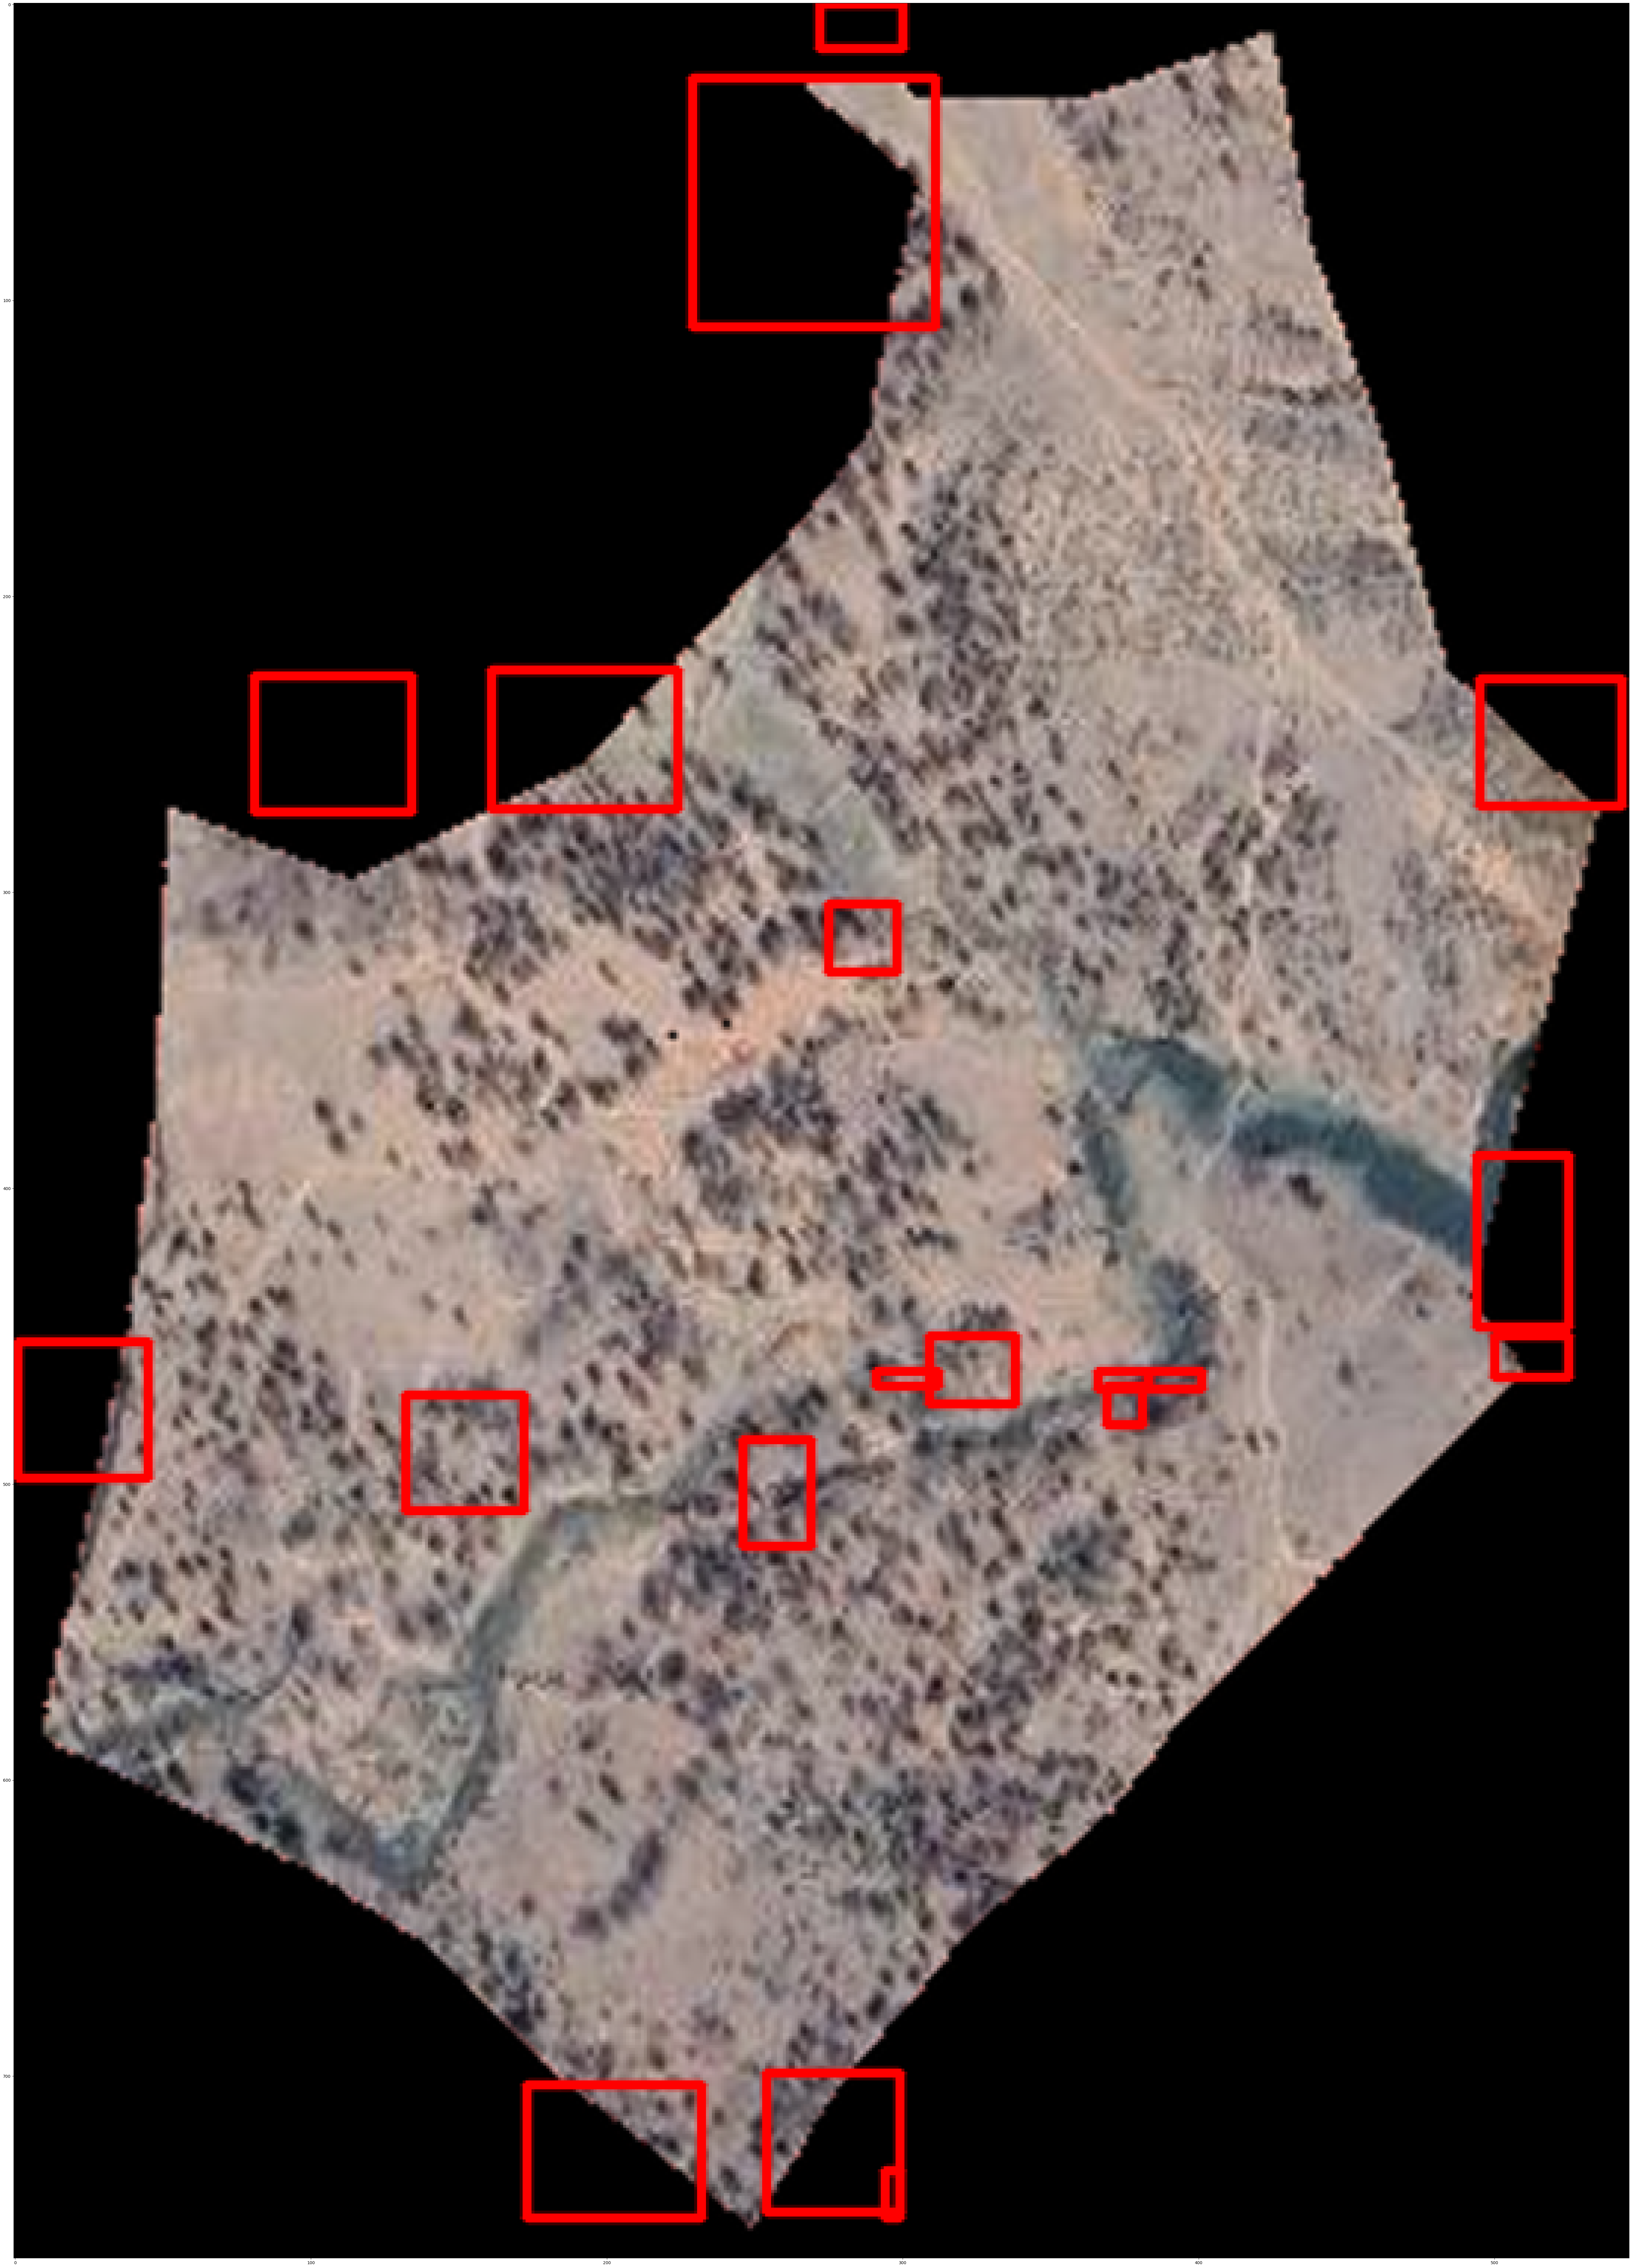

In [6]:
from deepforest import main
import matplotlib.pyplot as plt
import cv2
import tempfile
import os

model = main.deepforest()
model.use_release()

raster_path = "/content/resized_image.png"

image = cv2.imread(raster_path, cv2.IMREAD_UNCHANGED)  # Load image with alpha channel
image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
temp_dir = tempfile.mkdtemp()
temp_image_path = os.path.join(temp_dir, "modified_image.tif")
cv2.imwrite(temp_image_path, image)

predicted_raster = model.predict_tile(temp_image_path, return_plot=True, patch_size=300, patch_overlap=0.25, color=(255, 0, 0), thickness=2)
plt.figure(figsize=(99, 99))
plt.imshow(predicted_raster)
output_image_path = "/content/predicted_image.png"
plt.savefig(output_image_path)
plt.show()


# NO USE


In [ ]:
# @title Customize the Draw Points
variable_name = ""
from deepforest import main
import cv2
from google.colab.patches import cv2_imshow

raster_path = "/content/content.tif"
img = cv2.imread(raster_path)

my_model = main.deepforest()
my_model.use_release()

predicted_raster = my_model.predict_tile(raster_path, return_plot=False, patch_size=300, patch_overlap=0.25)

for n in range(len(predicted_raster)):
    x = (predicted_raster.xmin[n] + predicted_raster.xmax[n]) / 2
    y = (predicted_raster.ymin[n] + predicted_raster.ymax[n]) / 2
    cv2.circle(img, (int(x), int(y)), 25, (0, 255, 0), 2)

cv2.putText(img, 'TOTAL TREES: ' + str(len(predicted_raster)), (3, 14), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

cv2_imshow(img)
print('TOTAL TREES: ' + str(len(predicted_raster)))

Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 95.3MB/s]


No validation file provided. Turning off validation loop


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


NEON.pt: 129MB [00:04, 30.9MB/s]                           


Model was downloaded and saved to /usr/local/lib/python3.10/dist-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

6832 predictions in overlapping windows, applying non-max supression
4580 predictions kept after non-max suppression


/usr/local/lib/python3.10/dist-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


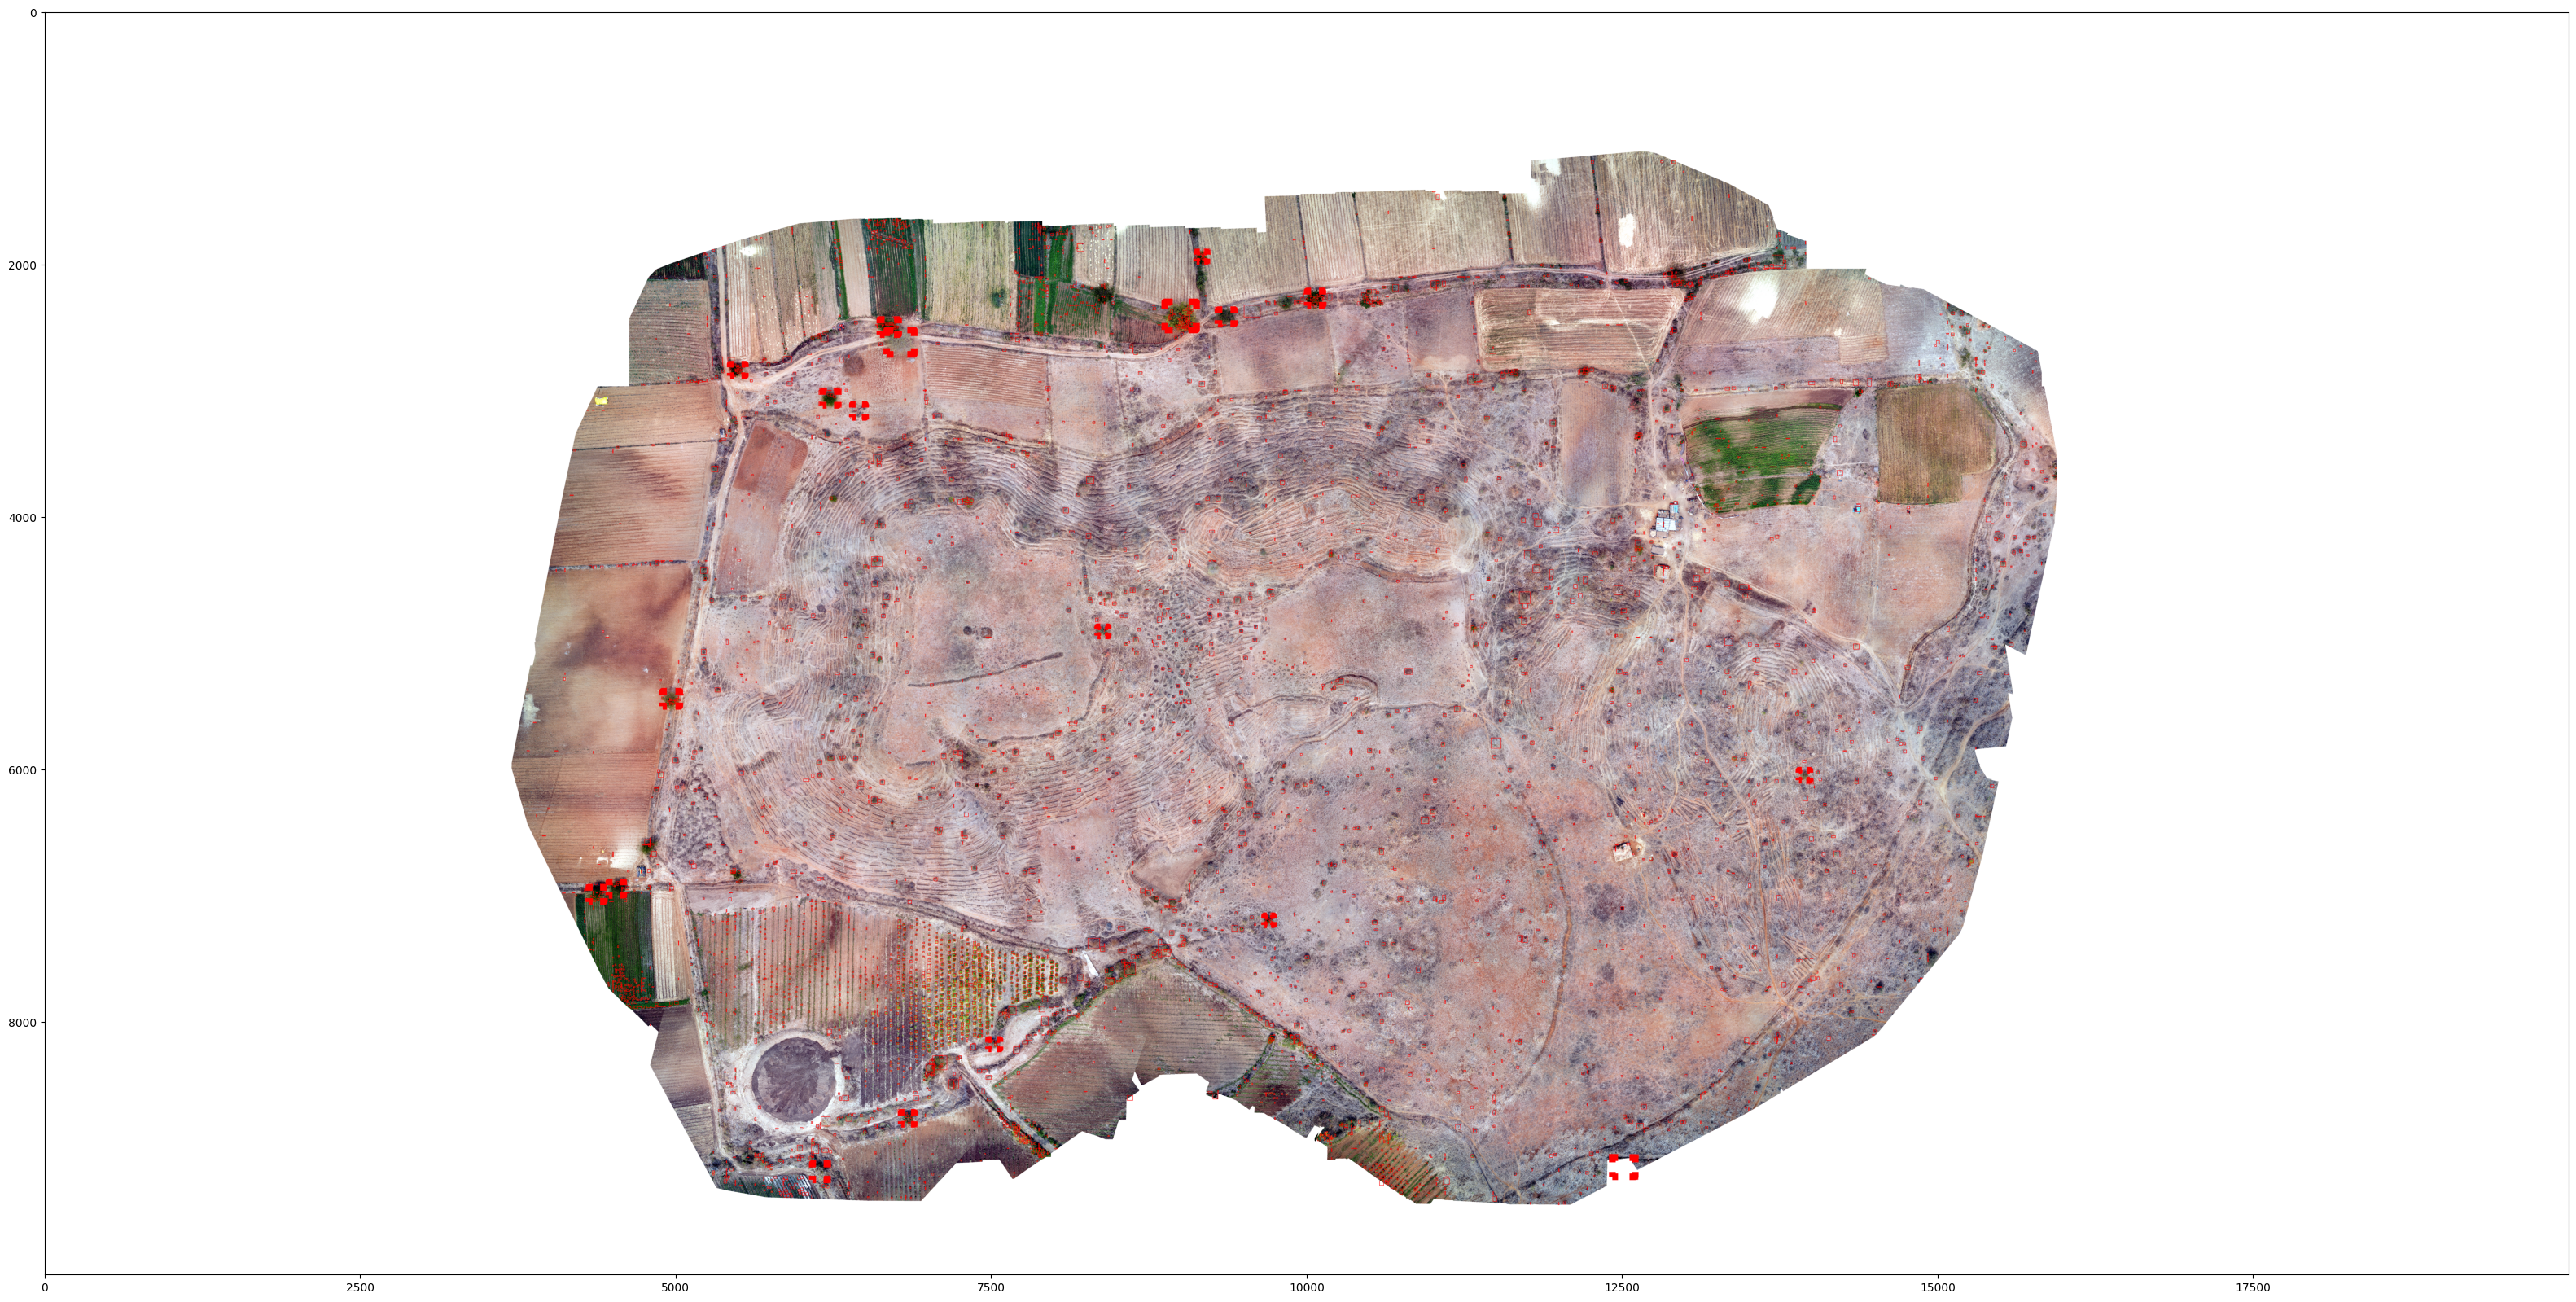

TOTAL TREES: 10000


In [ ]:
# @title Work well for Good TIF
from deepforest import main
from deepforest import get_data
import matplotlib.pyplot as plt

model = main.deepforest()
model.use_release()

raster_path = get_data("/content/drive/MyDrive/sanskar/Map.tif")
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=300,patch_overlap=0.25, color=(255, 0, 0), thickness=2)
plt.figure(figsize=(40, 40))
plt.imshow(predicted_raster)
plt.show()
print('TOTAL TREES: ' + str(len(predicted_raster)))

In [ ]:
# @title No use
'''
from deepforest import main, get_data
import matplotlib.pyplot as plt

model = main.deepforest()
model.use_release()

image_path = get_data("/content/Screenshot_1.png") #replace with your file
boxes = model.predict_image(path=image_path, return_plot=True, color=(0, 225, 0), thickness=3)
plt.imshow(boxes[:,:,::-1])  # Switch channel order for matplotlib
plt.show()

In [ ]:
# @title Circle image
"""
from deepforest import main
import cv2
from google.colab.patches import cv2_imshow

img_path = "/content/saff.png"
img = cv2.imread(img_path)

my_model = main.deepforest()
my_model.use_release()

box_info = my_model.predict_image(image=img, return_plot=False)

for n in range(len(box_info)):
    x = (box_info.xmin[n] + box_info.xmax[n]) / 2
    y = (box_info.ymin[n] + box_info.ymax[n]) / 2
    cv2.circle(img, (int(x), int(y)), 25, (0, 255, 0), 2)

cv2.putText(img, 'TOTAL TREES: ' + str(len(box_info)), (3, 14), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

cv2_imshow(img)
print('TOTAL TREES: ' + str(len(box_info)))"""

In [ ]:
# @title Multi KML to Link
"""
import csv
import os
import folium
import xml.etree.ElementTree as ET

def create_kmlmaps(kml_folder, output_folder):
    map_files = []

    for filename in os.listdir(kml_folder):
        if filename.endswith('.kml'):
            latitudes = []
            longitudes = []
            bounds = []

            m = folium.Map(location=[0, 0], zoom_start=10, tiles='http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google Satellite', name='Satellite', max_native_zoom=50, max_zoom=50)

            kml_path = os.path.join(kml_folder, filename)
            tree = ET.parse(kml_path)
            root = tree.getroot()

            features = []
            for placemark in root.findall('.//{http://www.opengis.net/kml/2.2}Placemark'):
                geometry_element = placemark.find('.//{http://www.opengis.net/kml/2.2}Polygon') or placemark.find('.//{http://www.opengis.net/kml/2.2}LineString')
                if geometry_element is not None:
                    coordinates = geometry_element.find('.//{http://www.opengis.net/kml/2.2}coordinates').text.strip()
                    coordinates = [list(map(float, coord.split(','))) for coord in coordinates.split()]

                    description_element = placemark.find('.//{http://www.opengis.net/kml/2.2}description')
                    description_text = description_element.text.strip() if description_element is not None else ''

                    lats = [coord[1] for coord in coordinates]
                    lons = [coord[0] for coord in coordinates]
                    avg_lat = sum(lats) / len(lats)
                    avg_lon = sum(lons) / len(lons)

                    latitudes.append(avg_lat)
                    longitudes.append(avg_lon)

                    bounds.extend(coordinates)

                    feature = {
                        "type": "Feature",
                        "properties": {
                            "description": description_text,
                            "color": "red",
                            "fillColor": "blue"
                        },
                        "geometry": {
                            "type": "Polygon",
                            "coordinates": [coordinates]
                        }
                    }
                    features.append(feature)

            geojson_data = {
                "type": "FeatureCollection",
                "features": features
            }

            folium.GeoJson(
                geojson_data,
                name=filename.split('.')[0],
                style_function=lambda x: {
                    "color": x["properties"]["color"],
                    "fillColor": x["properties"]["fillColor"],
                    "fillOpacity": 0.01
                },
                tooltip=folium.GeoJsonTooltip(fields=['description'], labels=False) if any(feature["properties"].get("description") for feature in features) else None
            ).add_to(m)

            if bounds:
                min_lat, min_lon = min(bounds, key=lambda x: x[1])[1], min(bounds, key=lambda x: x[0])[0]
                max_lat, max_lon = max(bounds, key=lambda x: x[1])[1], max(bounds, key=lambda x: x[0])[0]
                bounds = [[min_lat, min_lon], [max_lat, max_lon]]

                m.fit_bounds(bounds)

            folium.TileLayer(tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', attr='OpenStreetMap', name='OSM', max_native_zoom=20, max_zoom=20).add_to(m)
            folium.TileLayer(tiles='http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google Normal', name='Normal', max_native_zoom=20, max_zoom=20).add_to(m)
            folium.TileLayer(tiles='http://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google Hybrid', name='Hybrid', max_native_zoom=20, max_zoom=20).add_to(m)

            folium.LayerControl().add_to(m)

            map_file = os.path.join(output_folder, f"{filename.split('.')[0]}_plot_map.html")
            m.save(map_file)

            print(f"Map saved to {map_file}")
            map_files.append(map_file)

    return map_files

output_folder = '/content/'
kml_folder = '/content/kml'
output_links = create_kmlmaps(kml_folder, output_folder)

csv_file = 'map_links.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Map link'])
    for link in output_links:
        writer.writerow([f"file://{link}"])

print(f"Map links saved to {csv_file}")"""
